# Abstract Syntax Three Generation

## Imports

In [1]:
# System Imports
import os
import subprocess
import json

## Process `.c` files

Propose Files

In [ ]:
# Save the current working directory (location of the notebook)
current_dir = os.getcwd()

# Define paths relative to the current directory
victims_folder = os.path.join(current_dir, 'victims')
ripped_hearts_folder = os.path.join(current_dir, 'ripped_hearts')
ansi_folder = os.path.join(current_dir, 'ansi')

# Check if the directories exist, if not, create them
os.makedirs(ripped_hearts_folder, exist_ok=True)
os.makedirs(ansi_folder, exist_ok=True)

# List .c files in the 'victims' folder
def list_files(directory):
    return [f for f in os.listdir(directory) if f.endswith('.c')]

# List files in the victims folder
files_in_victims = list_files(victims_folder)

# Display available files
files_in_victims

['try.c']

Choose Victim

In [3]:
file = "try.c" 

Definition

In [4]:
def process_file(c_file):
    # Base name of the .c file (e.g., "try.c" becomes "try")
    base_name = os.path.splitext(c_file)[0].split('/')[-1]  # Get base name from path without subdirectories
    
    # Output paths for JSON and ANSI files
    json_output_path = os.path.join(ripped_hearts_folder, f'{base_name}_ast.json')  # Save directly in 'ripped_hearts'
    ansi_output_path = os.path.join(ansi_folder, f'{base_name}_ast.ansi')  # Save directly in 'ansi'

    # Run clang to generate AST in JSON format and save to the JSON file
    clang_ast_cmd_json = f'clang -Xclang -ast-dump=json -fsyntax-only {c_file} > {json_output_path}'
    subprocess.run(clang_ast_cmd_json, shell=True, check=True)

    # Run clang to generate AST with ANSI coloring and save to the ANSI file
    clang_ast_cmd_ansi = f'clang -Xclang -ast-dump -fsyntax-only {c_file} > {ansi_output_path}'
    subprocess.run(clang_ast_cmd_ansi, shell=True, check=True)

    return json_output_path, ansi_output_path


Process

In [5]:
# Process the chosen .c file and generate output
json_output_path, ansi_output_path = process_file(os.path.join(victims_folder, file))

# Display the paths of the generated files
json_output_path, ansi_output_path

('/home/franco/Dropbox/AA_Fra_Rosnati/B_Education/AA_University/AA_PoliMi/AA_Ing/01_Magistrale/HPC_engineering/4_sem_HPC/CTO_Agosta/COT_Project/QuantumC/ripped_hearts/try_ast.json',
 '/home/franco/Dropbox/AA_Fra_Rosnati/B_Education/AA_University/AA_PoliMi/AA_Ing/01_Magistrale/HPC_engineering/4_sem_HPC/CTO_Agosta/COT_Project/QuantumC/ansi/try_ast.ansi')

Confirm

In [6]:
# Display the paths of the generated output files
print(f"JSON output saved to: {json_output_path}")
print(f"ANSI output saved to: {ansi_output_path}")

JSON output saved to: /home/franco/Dropbox/AA_Fra_Rosnati/B_Education/AA_University/AA_PoliMi/AA_Ing/01_Magistrale/HPC_engineering/4_sem_HPC/CTO_Agosta/COT_Project/QuantumC/ripped_hearts/try_ast.json
ANSI output saved to: /home/franco/Dropbox/AA_Fra_Rosnati/B_Education/AA_University/AA_PoliMi/AA_Ing/01_Magistrale/HPC_engineering/4_sem_HPC/CTO_Agosta/COT_Project/QuantumC/ansi/try_ast.ansi


In [ ]:
import json
from dataclasses import dataclass
import graphviz
from typing import List, Optional, Union, Any, Dict
from IPython.display import Image, display


In [8]:
@dataclass
class ASTNode:
    kind: str
    id: Optional[str] = None
    loc: Optional[Dict] = None
    range: Optional[Dict] = None

@dataclass
class Type(ASTNode):
    qualType: Optional[str] = None

@dataclass
class BuiltinType(Type):
    pass

@dataclass
class TranslationUnitDecl(ASTNode):
    inner: List['Decl'] = None

@dataclass
class TypedefDecl(ASTNode):
    name: str = None
    type: Dict = None
    isImplicit: bool = False
    inner: List[ASTNode] = None

@dataclass
class FunctionDecl(ASTNode):
    name: str = None
    mangledName: str = None
    type: Dict = None
    inner: List['Stmt'] = None

@dataclass
class CompoundStmt(ASTNode):
    inner: List['Stmt'] = None

@dataclass
class DeclStmt(ASTNode):
    inner: List['Decl'] = None

@dataclass
class VarDecl(ASTNode):
    name: str = None
    type: Dict = None
    init: Union[str, ASTNode] = None
    inner: List[ASTNode] = None

@dataclass
class BinaryOperator(ASTNode):
    opcode: str = None
    type: Dict = None
    valueCategory: str = None
    inner: List[ASTNode] = None

@dataclass
class IntegerLiteral(ASTNode):
    value: str = None
    type: Dict = None
    valueCategory: str = None

@dataclass
class ReturnStmt(ASTNode):
    inner: List[ASTNode] = None

@dataclass
class DeclRefExpr(ASTNode):
    # "referencedDecl" often has { "id", "kind", "name", ... }
    name: str = None
    type: Dict = None
    valueCategory: str = None
    referencedDecl: Dict = None

@dataclass
class ImplicitCastExpr(ASTNode):
    type: Dict = None
    castKind: str = None
    valueCategory: str = None
    inner: List[ASTNode] = None



In [9]:
def read_json_file(file_path: str) -> str:
    with open(file_path, 'r') as file:
        return file.read()

def from_dict(data: Union[Dict, List]) -> Union[ASTNode, List, Any]:
    """
    Convert JSON (dictionary or list) into the corresponding dataclasses.
    """
    if isinstance(data, list):
        return [from_dict(item) for item in data]
    if not isinstance(data, dict):
        return data

    kind = data.get('kind')
    common = {
        'id': data.get('id'),
        'loc': data.get('loc'),
        'range': data.get('range'),
        'kind': kind
    }

    if kind == 'TranslationUnitDecl':
        return TranslationUnitDecl(
            inner=from_dict(data.get('inner', [])), 
            **common
        )
    elif kind == 'TypedefDecl':
        return TypedefDecl(
            name=data.get('name'),
            type=data.get('type'),
            isImplicit=data.get('isImplicit', False),
            inner=from_dict(data.get('inner', [])),
            **common
        )
    elif kind == 'BuiltinType':
        return BuiltinType(
            qualType=data.get('type', {}).get('qualType'),
            **common
        )
    elif kind == 'FunctionDecl':
        return FunctionDecl(
            name=data.get('name'),
            mangledName=data.get('mangledName'),
            type=data.get('type'),
            inner=from_dict(data.get('inner', [])),
            **common
        )
    elif kind == 'CompoundStmt':
        return CompoundStmt(
            inner=from_dict(data.get('inner', [])), 
            **common
        )
    elif kind == 'DeclStmt':
        return DeclStmt(
            inner=from_dict(data.get('inner', [])), 
            **common
        )
    elif kind == 'VarDecl':
        # Parse 'inner' array first
        var_inner = from_dict(data.get('inner', []))
        # Check the 'init' field
        var_init_data = data.get('init')
        if isinstance(var_init_data, dict):
            var_init = from_dict(var_init_data)
        else:
            var_init = None
            if isinstance(var_inner, list) and len(var_inner) == 1:
                possible_init = var_inner[0]
                if isinstance(possible_init, (BinaryOperator, IntegerLiteral, CompoundStmt, DeclStmt, VarDecl)):
                    var_init = possible_init

        return VarDecl(
            name=data.get('name'),
            type=data.get('type'),
            init=var_init if var_init is not None else var_init_data,
            inner=var_inner,
            **common
        )
    elif kind == 'BinaryOperator':
        return BinaryOperator(
            opcode=data.get('opcode'),
            type=data.get('type'),
            valueCategory=data.get('valueCategory'),
            inner=from_dict(data.get('inner', [])),
            **common
        )
    elif kind == 'IntegerLiteral':
        return IntegerLiteral(
            value=data.get('value'),
            type=data.get('type'),
            valueCategory=data.get('valueCategory'),
            **common
        )
    elif kind == 'ReturnStmt':
        return ReturnStmt(
            inner=from_dict(data.get('inner', [])), 
            **common
        )
    elif kind == 'DeclRefExpr':
        return DeclRefExpr(
            name=data.get('name'),
            type=data.get('type'),
            valueCategory=data.get('valueCategory'),
            referencedDecl=data.get('referencedDecl'),
            **common
        )

    elif kind == 'ImplicitCastExpr':
        return ImplicitCastExpr(
            type=data.get('type'),
            castKind=data.get('castKind'),
            valueCategory=data.get('valueCategory'),
            inner=from_dict(data.get('inner', [])),
            **common
        )

    else:
        # Catch-all
        return ASTNode(**common)

def json_to_dataclass(json_content: str) -> TranslationUnitDecl:
    data = json.loads(json_content)
    return from_dict(data)


In [10]:
def format_ast(node: Union[ASTNode, List, Any], indent: int = 0) -> List[str]:
    """
    Create a textual tree representation of the AST for debugging/inspection.
    """
    lines = []
    indent_str = ' ' * indent
    
    # If this is a list, recurse on each item
    if isinstance(node, list):
        for item in node:
            lines.extend(format_ast(item, indent))
        return lines
    
    # If it's not an ASTNode, just print the raw data
    if not isinstance(node, ASTNode):
        lines.append(f"{indent_str}{node}")
        return lines

    # Print the node's kind and ID
    lines.append(f"{indent_str}{node.kind} [id={node.id}]")
    
    if isinstance(node, TranslationUnitDecl):
        for decl in node.inner or []:
            lines.extend(format_ast(decl, indent + 2))
    elif isinstance(node, FunctionDecl):
        lines.append(f"{indent_str}  Name: {node.name}")
        if node.type:
            lines.append(f"{indent_str}  Type: {node.type.get('qualType', 'unknown')}")
        for stmt in node.inner or []:
            lines.extend(format_ast(stmt, indent + 2))
    elif isinstance(node, CompoundStmt):
        for child in node.inner or []:
            lines.extend(format_ast(child, indent + 2))
    elif isinstance(node, DeclStmt):
        for decl in node.inner or []:
            lines.extend(format_ast(decl, indent + 2))
    elif isinstance(node, VarDecl):
        lines.append(f"{indent_str}  Name: {node.name}")
        if node.type:
            lines.append(f"{indent_str}  Type: {node.type.get('qualType', 'unknown')}")
        if node.init:
            lines.append(f"{indent_str}  Init:")
            lines.extend(format_ast(node.init, indent + 4))
    elif isinstance(node, BinaryOperator):
        lines.append(f"{indent_str}  Op: {node.opcode}")
        if node.inner:
            if len(node.inner) > 0:
                lines.append(f"{indent_str}  LHS:")
                lines.extend(format_ast(node.inner[0], indent + 4))
            if len(node.inner) > 1:
                lines.append(f"{indent_str}  RHS:")
                lines.extend(format_ast(node.inner[1], indent + 4))
    elif isinstance(node, IntegerLiteral):
        lines.append(f"{indent_str}  Value: {node.value}")
    elif isinstance(node, ReturnStmt):
        if node.inner:
            lines.append(f"{indent_str}  Return:")
            lines.extend(format_ast(node.inner[0], indent + 4))
    elif isinstance(node, DeclRefExpr):
        lines.append(f"{indent_str}  Name: {node.name}")
        if node.type:
            lines.append(f"{indent_str}  Type: {node.type.get('qualType', 'unknown')}")
        # If you want to show which VarDecl it references:
        if node.referencedDecl:
            lines.append(f"{indent_str}  references: {node.referencedDecl.get('name')} (id={node.referencedDecl.get('id')})")

    elif isinstance(node, ImplicitCastExpr):
        if node.type:
            lines.append(f"{indent_str}  Type: {node.type.get('qualType', 'unknown')}")
        if node.castKind:
            lines.append(f"{indent_str}  CastKind: {node.castKind}")
        # Recurse on inner
        for child in node.inner or []:
            lines.extend(format_ast(child, indent + 2))


    return lines


In [11]:
def ast_to_graphviz(node: ASTNode, graph: graphviz.Digraph, parent_id: str = None, edge_label: str = "") -> None:
    """
    Recursively add AST nodes to Graphviz diagram with enhanced operator visualization
    and handle all statement types (CompoundStmt, DeclStmt, etc.).
    """
    node_id = str(id(node))
    
    # Default label is just the node's kind:
    label = f"{node.kind}"

    # Add more descriptive labels for certain node types
    if isinstance(node, BinaryOperator):
        label = f"Binary Operator\n{node.opcode}"
    elif isinstance(node, IntegerLiteral):
        label = f"Integer Literal\n{node.value}"
    elif isinstance(node, VarDecl):
        label = f"Variable Declaration\n{node.name}"
    elif isinstance(node, CompoundStmt):
        label = f"Compound Statement"
    elif isinstance(node, DeclStmt):
        label = f"Declaration Statement"

    # Optionally add type info if available
    if hasattr(node, 'type') and node.type:
        qual = node.type.get('qualType', 'unknown')
        label += f"\nType: {qual}"

    # Create the Graphviz node
    graph.node(node_id, label=label)

    # Link to the parent, if any
    if parent_id:
        graph.edge(parent_id, node_id, label=edge_label)

    # ------------------
    # RECURSE
    # ------------------
    if isinstance(node, TranslationUnitDecl) and node.inner:
        for child in node.inner:
            ast_to_graphviz(child, graph, node_id)

    elif isinstance(node, FunctionDecl) and node.inner:
        for child in node.inner:
            ast_to_graphviz(child, graph, node_id)

    elif isinstance(node, CompoundStmt) and node.inner:
        for child in node.inner:
            ast_to_graphviz(child, graph, node_id)

    elif isinstance(node, DeclStmt) and node.inner:
        for decl in node.inner:
            ast_to_graphviz(decl, graph, node_id)

    elif isinstance(node, VarDecl) and node.init:
        if isinstance(node.init, ASTNode):
            ast_to_graphviz(node.init, graph, node_id, "init")

    elif isinstance(node, BinaryOperator) and node.inner:
        if len(node.inner) > 0:
            ast_to_graphviz(node.inner[0], graph, node_id, "LHS")
        if len(node.inner) > 1:
            ast_to_graphviz(node.inner[1], graph, node_id, "RHS")

    elif isinstance(node, ReturnStmt) and node.inner:
        ast_to_graphviz(node.inner[0], graph, node_id, "value")
    elif isinstance(node, DeclRefExpr):
        label = f"DeclRefExpr\n{node.name}"
        if hasattr(node, 'type') and node.type:
            label += f"\nType: {node.type.get('qualType', 'unknown')}"
        if node.referencedDecl:
            label += f"\nref -> {node.referencedDecl.get('name','?')}"
        graph.node(node_id, label=label)
        # Link to parent if needed
        if parent_id:
            graph.edge(parent_id, node_id, edge_label)

    elif isinstance(node, ImplicitCastExpr):
        label = f"ImplicitCastExpr"
        if node.castKind:
            label += f"\n({node.castKind})"
        if hasattr(node, 'type') and node.type:
            label += f"\nType: {node.type.get('qualType','unknown')}"
        graph.node(node_id, label=label)
        if parent_id:
            graph.edge(parent_id, node_id, edge_label)

        # Recurse
        for child in node.inner or []:
            ast_to_graphviz(child, graph, node_id)



In [12]:
def save_ast_image(root: ASTNode, output_path: str = "ast") -> None:
    """
    Create and save a Graphviz-based AST visualization (PNG file).
    """
    dot = graphviz.Digraph(comment='AST', format='png')
    dot.attr(rankdir='TB', splines='ortho')
    dot.attr('node', shape='box', style='rounded,filled', 
             fontname='Helvetica', fillcolor='#E0E0E0')
    dot.attr('edge', arrowsize='0.7', fontname='Helvetica')
    
    ast_to_graphviz(root, dot)
    dot.render(output_path, cleanup=True)
    print(f"AST visualization saved to {output_path}.png")


def save_ast_image_from_function(func_node: ASTNode, output_path: str = "ast_func") -> None:
    """
    Create and save a Graphviz-based AST visualization *starting from the function node*.
    """
    dot = graphviz.Digraph(comment='Function AST', format='png')
    dot.attr(rankdir='TB', splines='ortho')
    dot.attr('node', shape='box', style='rounded,filled', 
             fontname='Helvetica', fillcolor='#E0E0E0')
    dot.attr('edge', arrowsize='0.7', fontname='Helvetica')
    
    ast_to_graphviz(func_node, dot)
    dot.render(output_path, cleanup=True)
    print(f"Function-only AST visualization saved to {output_path}.png")


In [13]:
def show_ast_image(root: ASTNode) -> Image:
    """
    Return an inline image (IPython.display.Image) for the *entire* AST.
    """
    dot = graphviz.Digraph(comment='AST')
    dot.attr(rankdir='TB', splines='ortho')
    dot.attr('node', shape='box', style='rounded,filled', 
             fontname='Helvetica', fillcolor='#E0E0E0')
    dot.attr('edge', arrowsize='0.7', fontname='Helvetica')
    
    ast_to_graphviz(root, dot)
    png_data = dot.pipe(format='png')
    return Image(png_data)

def show_ast_image_from_function(func_node: ASTNode) -> Image:
    """
    Return an inline image (IPython.display.Image) for a *single function* subtree.
    """
    dot = graphviz.Digraph(comment='Function AST')
    dot.attr(rankdir='TB', splines='ortho')
    dot.attr('node', shape='box', style='rounded,filled', 
             fontname='Helvetica', fillcolor='#E0E0E0')
    dot.attr('edge', arrowsize='0.7', fontname='Helvetica')
    
    ast_to_graphviz(func_node, dot)
    png_data = dot.pipe(format='png')
    return Image(png_data)


In [14]:
# Path to your JSON file (same as you'd pass on the command line)
json_path = "ripped_hearts/try_ast.json"  # Change as needed

In [15]:
# Read file, parse AST
json_content = read_json_file(json_path)
root = json_to_dataclass(json_content)

# Print textual representation
print("Text representation:")
print("\n".join(format_ast(root)))


Text representation:
TranslationUnitDecl [id=0x5986aa5df3b8]
  TypedefDecl [id=0x5986aa5dfbe8]
  TypedefDecl [id=0x5986aa5dfc58]
  TypedefDecl [id=0x5986aa5dff60]
  TypedefDecl [id=0x5986aa5e0008]
  TypedefDecl [id=0x5986aa5e0300]
  FunctionDecl [id=0x5986aa63f628]
    Name: main
    Type: int ()
    CompoundStmt [id=0x5986aa63f920]
      DeclStmt [id=0x5986aa63f7f8]
        VarDecl [id=0x5986aa63f730]
          Name: sum
          Type: int
          Init:
            BinaryOperator [id=0x5986aa63f7d8]
              Op: +
              LHS:
                IntegerLiteral [id=0x5986aa63f798]
                  Value: 2
              RHS:
                IntegerLiteral [id=0x5986aa63f7b8]
                  Value: 3
      DeclStmt [id=0x5986aa63f908]
        VarDecl [id=0x5986aa63f828]
          Name: sub
          Type: int
          Init:
            BinaryOperator [id=0x5986aa63f8e8]
              Op: -
              LHS:
                ImplicitCastExpr [id=0x5986aa63f8d0]
           

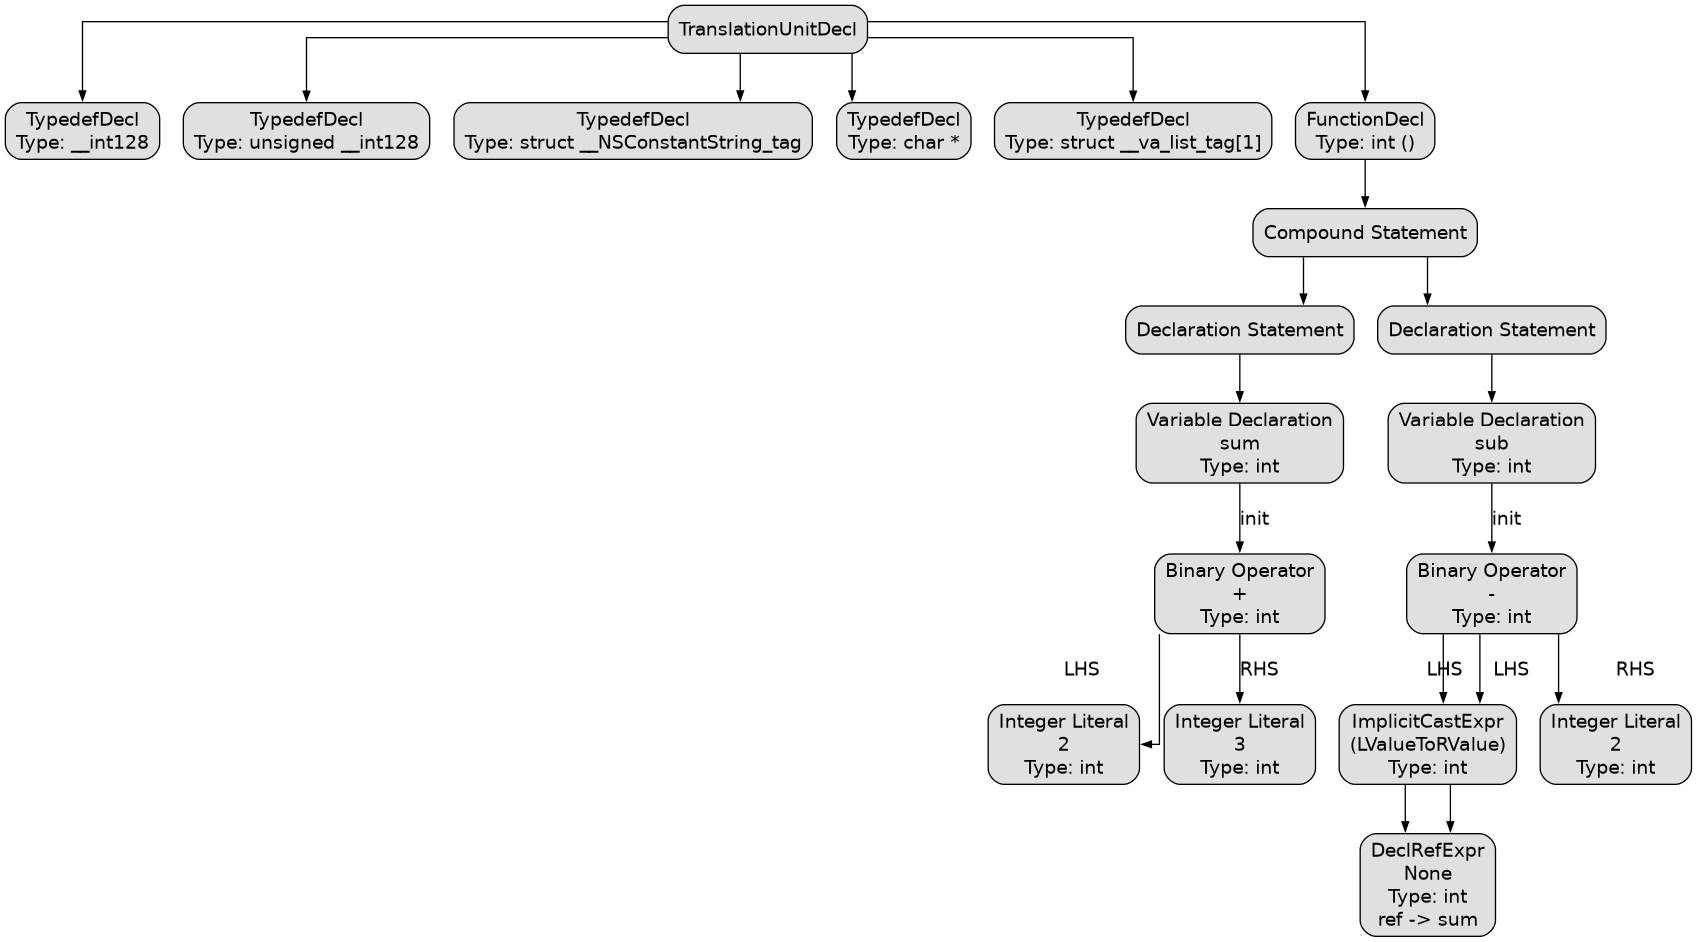

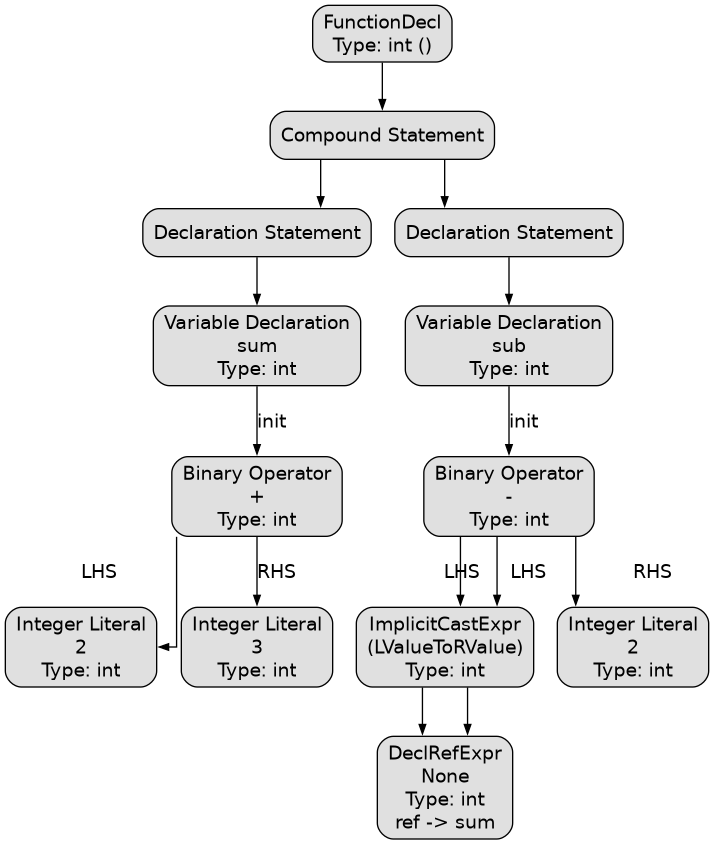

In [16]:
# 1) Show the *entire* AST inline
display(show_ast_image(root))

# 2) Locate the "main" function, if it exists
main_func = None
if isinstance(root, TranslationUnitDecl) and root.inner:
    for child in root.inner:
        if isinstance(child, FunctionDecl) and child.name == "main":
            main_func = child
            break

# 3) If found, display the subtree for that function
if main_func is not None:
    display(show_ast_image_from_function(main_func))
else:
    print("No function named 'main' found in the AST.")


In [17]:
def write_ast_instances_txt(root: ASTNode, file_path: str = "ast_instances.txt"):
    """
    Recursively traverse the AST, writing each node's kind, ID, and attributes
    (including any children) to a .txt file. This captures the *actual parsed*
    instances, not just the dataclass definitions.
    """
    from dataclasses import fields
    
    visited = set()

    def dump_node(node: ASTNode, depth: int = 0):
        if not node:
            return
        
        # Use id(node) for visited-check, so no "unhashable type" error
        if id(node) in visited:
            return
        visited.add(id(node))
        
        indent = "  " * depth
        
        # Append info to the file
        with open(file_path, "a", encoding="utf-8") as f:
            f.write(f"{indent}Node kind: {node.kind}\n")
            f.write(f"{indent}  id: {node.id}\n")
            for field in fields(node):
                field_name = field.name
                value = getattr(node, field_name)

                # If it's another ASTNode, just indicate its kind & ID
                if isinstance(value, ASTNode):
                    f.write(f"{indent}  {field_name}: [ASTNode: {value.kind}, id={value.id}]\n")
                else:
                    # Could be a dict, list, string, or None
                    f.write(f"{indent}  {field_name}: {value}\n")
            f.write("\n")
        
        # Now recurse into any child fields that might hold ASTNodes
        for field in fields(node):
            val = getattr(node, field.name)
            if isinstance(val, ASTNode):
                dump_node(val, depth + 1)
            elif isinstance(val, list):
                for item in val:
                    if isinstance(item, ASTNode):
                        dump_node(item, depth + 1)

    # Overwrite/clear file initially
    with open(file_path, "w", encoding="utf-8") as f:
        f.write("=== AST Instances Dump ===\n\n")

    # Start recursion from the root
    dump_node(root, 0)

    print(f"AST instances have been written to '{file_path}'")

write_ast_instances_txt(root, "ast_instances.txt")


AST instances have been written to 'ast_instances.txt'
